In [1]:
# import tensorflow.compat.v1 as tf
# from tensorflow.compat.v1 import keras
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imsave, imshow
import numpy as np
import pandas as pd
import math
from scipy.signal import convolve2d
from skimage import img_as_ubyte, img_as_float
from skimage.transform import resize
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
# from keras import Sequential
# from keras import layers
import copy
from skimage.color import rgb2gray
from sklearn.metrics import mean_squared_error as MSE
import gc
import os.path
gc.enable()

# tf.keras.backend.clear_session()  # For easy reset of notebook state.
# sess = tf.Session() 
# keras.backend.set_session(sess)


def make_ker(ker_len, ker_angle):
#     h = ker_len * 2
    h = ker_len
    ker_len = ker_len // 2
    ker = np.zeros((h, h), dtype='float')
    k = -math.tan(ker_angle)
    b = (1 - k) * ker_len
    if abs(abs(ker_angle * 180/math.pi) - 90) > 10:
        for x in range(h):
            y = round(k * x + b)
            y = int((y if y >= 0 else 0) if y <= h-1 else h-1)
            if (y == 0 or y == h - 1):
                continue
            ker[y, x] = 1
    else:
        for y in range(h):
            ker[y, ker_len] = 1 
    ret_value = ker/ker.sum()
    if np.isnan(np.sum(ret_value)):
        return []
    else:
        return ret_value

In [2]:
import random
from skimage.transform import SimilarityTransform
from skimage.transform import warp
from skimage.util import random_noise

IMG_SIZE = 200
BLUR_LEN = 5
# IMG_SIZE = None
# OUT_SIZE = 600
BATCH_SIZE = 8
EPS = 10e-7

def rotate_transform_matrix(transform):
    """Rotate matrix so it can be applied to row:col coordinates."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)]
    return type(transform)(matrix)

def prepare_img(img):
    image = copy.copy(img)
    if len(image.shape) == 2:
        image = np.stack((image, image, image))
        image = np.transpose(image, axes=(1,2, 0))
    for channel in range(3):
        image[:,:,channel] = (image[:,:,channel] - np.mean(image[:,:,channel])) / (np.std(image[:,:,channel]) + EPS)
    if (image.shape[2] == 4):
        image = image[:,:,:3]
    h, w = image.shape[:2]
    return image

def prepare_img1(img):
    image = copy.copy(img)
    if len(image.shape) == 2:
        image = np.stack((image, image, image))
        image = np.transpose(image, axes=(1,2, 0))
    if (image.shape[2] == 4):
        image = image[:,:,:3]
    return img_as_float(image)

# train_generator = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1)
# train_generator.fit(X, augment=True, seed=42)


In [3]:
import random

In [4]:
IMG_SIZE = 600
BLUR_LEN = 5
KER = make_ker(5, 0)
global_idx = 0

def generate_pics(paths, amount_on_picture, break_on = 0):
    global global_idx
    for p in paths:
        try:
            cur_img = prepare_img1(imread(p))
            blurred = convolve_img(cur_img)
            noised = random_noise(blurred, var=0.001)
            h, w = cur_img.shape[:2]
            if (h > IMG_SIZE and w > IMG_SIZE):
                for idx in range(amount_on_picture):
                    y = random.randrange(h - IMG_SIZE)
                    x = random.randrange(w - IMG_SIZE)
                    plt.imsave('pict/random_la/bn/img_' + str(global_idx) + '.png', noised[y : y + IMG_SIZE, x : x + IMG_SIZE])
                    plt.imsave('pict/random_la/sn/img_' + str(global_idx) + '.png', cur_img[y : y + IMG_SIZE, x : x + IMG_SIZE])
                    global_idx += 1
            if (break_on != 0):
                if (break_on == global_idx):
                    return
        except:
            pass

def generate_pics_from_two(paths_X, paths_y, amount_on_picture):
    global_idx = 0
    for p in range(len(paths_X)):
        blurred = prepare_img1(imread(paths_X[p]))
        cur_img = prepare_img1(imread(paths_y[p]))
        h, w = cur_img.shape[:2]
        for idx in range(amount_on_picture):
            y = random.randrange(h - IMG_SIZE)
            x = random.randrange(w - IMG_SIZE)
            plt.imsave('pict/b_test/test_' + str(global_idx) + '.png', blurred[y : y + IMG_SIZE, x : x + IMG_SIZE])
            plt.imsave('pict/s_test/test_' + str(global_idx) + '.png', cur_img[y : y + IMG_SIZE, x : x + IMG_SIZE])
            global_idx += 1
    return

def convolve_img(image):
    # ker = KER
        ker = make_ker(random.randint(2, 15), random.uniform(0, np.pi))
        ker_len = BLUR_LEN
        pad = ker_len // 2
        img = image
        if len(img.shape) == 2:
            img = np.stack((image, image, image))
            img = np.transpose(image, axes=(1,2, 0))
        # for channel in range(3):
            # image[:,:,channel] = (image[:,:,channel] - np.mean(image[:,:,channel])) / (np.std(image[:,:,channel]) + EPS)
        r = convolve2d(np.pad(img[:,:,0], pad, 'edge'), ker, mode='valid'); #r /= r.max()
        g = convolve2d(np.pad(img[:,:,1], pad, 'edge'), ker, mode='valid'); #g /= g.max()
        b = convolve2d(np.pad(img[:,:,2], pad, 'edge'), ker, mode='valid'); #b /= b.max()
        image = np.stack((r, g, b))
        image = np.clip(image, 0., 1.)
        image = np.transpose(image, axes=(1,2, 0))
        return image
        print(ker)

In [ ]:
# generate_pics_from_two(X, y, 1)
generate_pics(y, 1, break_on=300)

In [94]:
%%time
# train_dir = '../course/motion_blurred/'
# train_dir = 'b/'
y_dir = 'pict/random_la/bn/'
# y_dir = 'pict/s_/'
# y_dir = 's/'
# fnames_X = listdir(train_dir)
fnames_y = os.listdir(y_dir)
fnames_y.sort()
# X = list([train_dir + item for item in fnames_X])
y = list([y_dir + item for item in fnames_y])

CPU times: user 1.7 ms, sys: 4 µs, total: 1.7 ms
Wall time: 889 µs


In [6]:
import prox_tv as ptv

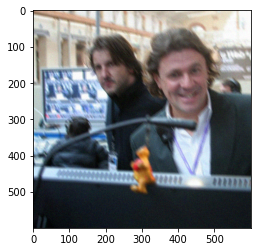

In [7]:
img = prepare_img1(plt.imread(y[0]))
plt.imshow(img)

In [83]:
import os
def deconvolve_img(image, params=[0.001, .1, 1, 1]):
    ker = KER
#         ker = make_ker(random.randint(2, 15), random.uniform(0, np.pi))
    ker_len = 5
    pad = ker_len // 2
    img = image
    if len(img.shape) == 2:
        img = np.stack((image, image, image))
        img = np.transpose(image, axes=(1,2, 0))
    # for channel in range(3):
        # image[:,:,channel] = (image[:,:,channel] - np.mean(image[:,:,channel])) / (np.std(image[:,:,channel]) + EPS)
#     r = np.pad(img[:,:,0], pad, 'edge')
#     g = np.pad(img[:,:,1], pad, 'edge')
#     b = np.pad(img[:,:,2], pad, 'edge')
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    print(r.shape)
    
    ker_full = convolve2d(np.ones_like(r), ker, mode='same')
    #tv1w_2d(X, W1, W2) w1[(M-1) x N], w2 [M x (N-1)]
#     w2 = ker_full[:, :-1]
    w1 = ker_full[:-1, :]
#     w1 = np.ones_like(r)[:-1, :]
#     w2 = np.ones_like(r)[:, :-1]
    w2 = ker_full[:, :-1]
    
    r = ptv.tvp_2d(r, params[0], params[1], params[2], params[3], max_iters=100)
    g = ptv.tvp_2d(g, params[0], params[1], params[2], params[3], max_iters=100)
    b = ptv.tvp_2d(b, params[0], params[1], params[2], params[3], max_iters=100)
#     r = ptv.tvp_2d(r, w1, w2, max_iters=0)
#     g = ptv.tv1w_2d(g, w1, w2, max_iters=0)
#     b = ptv.tv1w_2d(b, w1, w2, max_iters=0)
    image = np.stack((r, g, b))
    image = np.clip(image, 0., 1.)
    image = np.transpose(image, axes=(1,2, 0))
    return image


In [78]:
%%time
a = deconvolve_img(img, params=[.1, .0001, 1, 1])

(600, 600)
CPU times: user 3.39 s, sys: 7.98 ms, total: 3.4 s
Wall time: 3.4 s


In [79]:
(img -a).max()

0.1999999999999993

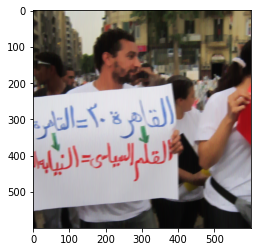

In [80]:
plt.imshow(a)

In [101]:
params = [ 
          [.001, .1, .001, .1],
          [.001, .1, .1, .001],
          [.1, .001, .1, .001],
          [.1, .001, .001, .1]
         ]
for cur_param in params:
    dir_name = 'pict/random_la/deconv' + str(cur_param) + '/'
    if (not os.path.exists(dir_name)):
        print(dir_name)
        os.mkdir(dir_name)
        for idx, p in enumerate(y):
            img = prepare_img1(plt.imread(p))
            plt.imsave(dir_name + fnames_y[idx], deconvolve_img(img))
            if(idx == 30):
                break

pict/random_la/deconv[0.001, 0.1, 0.001, 0.1]/
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
pict/random_la/deconv[0.001, 0.1, 0.1, 0.001]/
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
pict/random_la/deconv[0.1, 0.001, 0.1, 0.001]/
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(600, 600)
(